# 📌 **Cross-Framework Branched Architecture Exercise**

This notebook implements the same multi-branch regression architecture in **TensorFlow/Keras**, **PyTorch**, and **JAX/Flax** to unify my understanding of neural network construction across major deep learning frameworks.
The goal was not to train models, but to master **architectural reasoning** and **functional-style dataflow thinking** in each ecosystem.

### **Key Outcomes**

* Built an identical branched model (two parallel feature pathways → merge → hidden layer → output) in all three frameworks.
* Used a **functional programming interpretation** for each implementation: models as pure transformations, layers as parametric functions, and the forward pass as a composed data pipeline.
* Solidified mental models of:

  * **Keras** as a declarative functional graph builder.
  * **PyTorch** as an explicit, step-wise transformation executor.
  * **JAX/Flax** as a pure functional transformer with lazy parameter creation.
* Identified the common architecture pattern behind all frameworks, proving transferability of skills and enabling future multi-framework work in research or engineering contexts.

### **Why This Matters**

This exercise is to help eliminate framework-specific confusion, build true architectural fluency, and set the foundation for writing **custom loss functions**, **custom layers**, and **non-sequential models** with confidence.




In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing as fc

In [ ]:
df = fc(as_frame =True)

In [ ]:
x = pd.DataFrame(df.data)

In [ ]:
y = pd.DataFrame(df.target)

In [ ]:
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras import Model

# 🔹 Pure data placeholder — no computation yet, just a shape contract
inputs = Input(shape=(x.shape[1],))

# 🔹 Branch 1: apply a pure transformation (Linear + Relu)
x_main = Dense(64, activation='relu')(inputs)

# 🔹 Branch 2: another independent transformation of the same input
y_main = Dense(34, activation='relu')(inputs)

# 🔹 Combine two independent feature transformations
merged = Concatenate()([x_main, y_main])

# 🔹 Final transformation → map merged representation to scalar
output = Dense(1)(merged)

# 🔹 Assemble the computation graph as a pure functional mapping
model = Model(inputs=inputs, outputs=output)


In [ ]:
# Initialize the model with input shape
model.build(input_shape = (None, x.shape[1]))

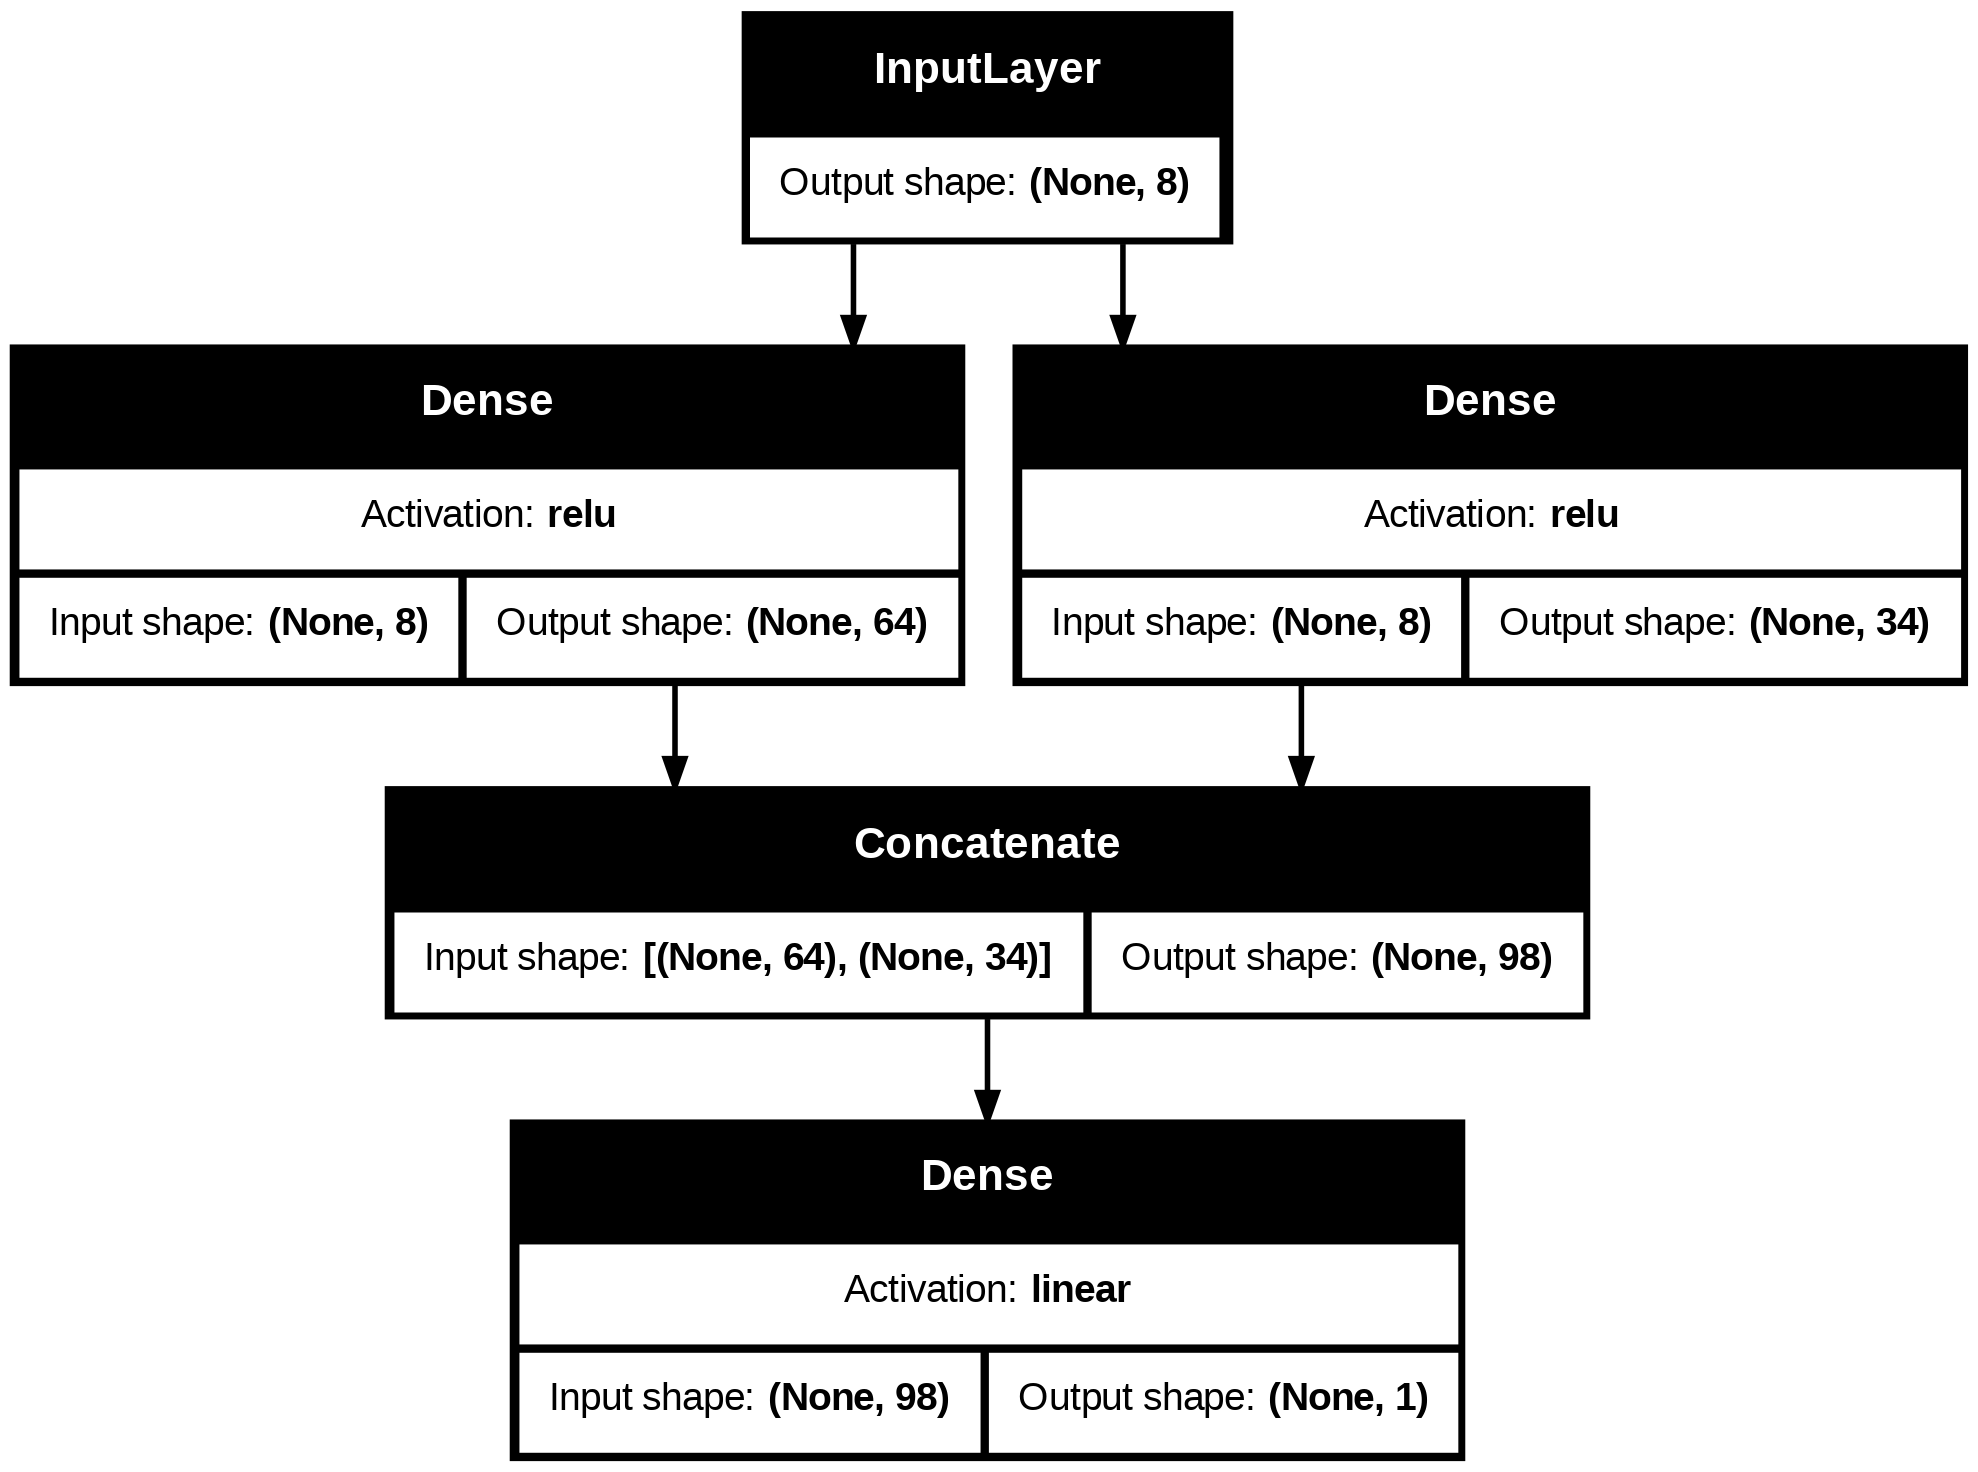

In [ ]:
# Build and plot graph of the model.
from tensorflow.keras.utils import plot_model

# Create the visualization
plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  # TB = top to bottom, LR = left to right
    dpi=96,
    show_layer_activations=True
)

# Or display directly in notebook
plot_model(model, show_shapes=True, show_layer_activations=True)

Same Branched model from pytorch.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BranchRegression(nn.Module):
    def __init__(self, input_size, h1, h2, h3, out):
        super().__init__()

        # 🔹 Branch blueprints — parametric pure transforms
        self.branch1 = nn.Linear(input_size, h1)
        self.branch2 = nn.Linear(input_size, h2)

        # 🔹 Merge transform — maps concatenated features to new space
        self.layer = nn.Linear(h1 + h2, h3)

        # 🔹 Final projection to scalar output
        self.output = nn.Linear(h3, out)

    def forward(self, x):
        # 🔹 Apply branch-specific transformations
        b1 = F.relu(self.branch1(x))   # Pure function: x → feature_1
        b2 = F.relu(self.branch2(x))   # Pure function: x → feature_2

        # 🔹 Concatenate feature transforms (functional combination)
        merged = torch.cat([b1, b2], dim=1)

        # 🔹 Apply post-merge transformation
        hidden = F.relu(self.layer(merged))

        # 🔹 Map hidden representation → final scalar
        out = self.output(hidden)

        # 🔹 Forward returns the result of composed functions
        return out


In [ ]:
model = BranchRegression(x.shape[1],64,32,16,1)

In [ ]:
import jax
import jax.numpy as jnp
from flax import linen as nn

class BranchRegression_jax(nn.Module):
    @nn.compact
    def __call__(self, x):
        # 🔹 Branch 1: pure transformation — parameters created lazily
        b1 = nn.relu(nn.Dense(64)(x))

        # 🔹 Branch 2: another pure transform — independent path
        b2 = nn.relu(nn.Dense(32)(x))

        # 🔹 Functional merge — no side effects, pure concat
        merged = jnp.concatenate([b1, b2], axis=1)

        # 🔹 Post-merge transformation
        hidden = nn.relu(nn.Dense(32)(merged))

        # 🔹 Final scalar projection
        out = nn.Dense(1)(hidden)

        # 🔹 Entire model is a pure function: params + x → y
        return out

model_jax = BranchRegression_jax()


In [ ]:

x_jax = jnp.array(x.values)

params = model_jax.init(jax.random.PRNGKey(42),jnp.ones((1,x.shape[1])))
